# Writing a Faster R-CNN model from scratch


In [8]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

!pip install opencv-python

import cv2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision.datasets import VOCDetection

import os
import xml.etree.ElementTree as ET

import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet50
from torchvision.transforms import transforms
import math
from torchvision.models.detection.rpn import AnchorGenerator

from sklearn.model_selection import train_test_split
from numpy.core.fromnumeric import resize
import cv2
from torchvision.transforms import ToTensor
from torchvision.ops import RoIAlign
import torch.nn as nn

In [4]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar

--2023-10-30 20:26:21--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  28.3MB/s    in 72s     

2023-10-30 20:27:33 (26.5 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [26]:
def parse_annotations(anno_path):
    """
    Parses PASCAL VOC annotations and extracts bounding box details and their
    corresponding labels for each image.

    Parameters:
    - anno_path (str): Path to the directory containing the XML annotations.

    Returns:
    - dict: Dictionary mapping image filenames (without extension) to a list
            of bounding box details (dict format).
    """
    img_annotations = {}

    # Define a label to integer mapping
    label_map = {
        'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3,
        'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8,
        'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12,
        'motorbike': 13, 'person': 14, 'pottedplant': 15,
        'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
    }

    for file in os.listdir(anno_path):
        if file.endswith('.xml'):
            file_path = os.path.join(anno_path, file)

            try:
                tree = ET.parse(file_path)
                root = tree.getroot()
            except ET.ParseError:
                print(f"Error parsing {file}")
                continue

            boxes = []
            for obj in root.findall('object'):
                label = obj.find('name').text
                box = obj.find('bndbox')

                # Check if all necessary information is available
                if label is None or box is None:
                    continue

                try:
                    xmin = int(round(float(box.find('xmin').text)))
                    ymin = int(round(float(box.find('ymin').text)))
                    xmax = int(round(float(box.find('xmax').text)))
                    ymax = int(round(float(box.find('ymax').text)))
                except (TypeError, ValueError):
                    # In case of missing or malformed bounding box info
                    continue

                boxes.append({
                    "label": label_map.get(label, -1),  # Use the integer mapping; -1 for unknown labels
                    "xmin": xmin,
                    "ymin": ymin,
                    "xmax": xmax,
                    "ymax": ymax
                })

            if boxes:
                img_annotations[file[:-4]] = boxes

    return img_annotations, label_map

anno_path = 'VOCdevkit/VOC2012/Annotations'
annotations, label_map = parse_annotations(anno_path)
inverse_label_map = {v: k for k, v in label_map.items()}
print(annotations.get('2012_000051'))

[{'label': 14, 'xmin': 9, 'ymin': 206, 'xmax': 33, 'ymax': 261}, {'label': 14, 'xmin': 103, 'ymin': 201, 'xmax': 123, 'ymax': 245}]


In [11]:
# Dataset class
class VOCDataset(Dataset):
    def __init__(self, img_dir, annotations, transform=None):
        self.img_dir = img_dir
        self.img_names = list(annotations.keys())
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name + '.jpg')
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        boxes = []
        labels = []
        for anno in self.annotations[img_name]:
            boxes.append([anno['xmin'], anno['ymin'], anno['xmax'], anno['ymax']])
            labels.append(anno['label'])
        boxes = torch.tensor(boxes, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        # Construct target dictionary for each image
        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.tensor(labels, dtype=torch.int64)

        return image, target


In [14]:
def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

img_annotations = parse_annotations('VOCdevkit/VOC2012/Annotations')
img_names = list(img_annotations.keys())
split = int(0.8 * len(img_names))
X_train = img_names[:split]
X_test = img_names[split:]

# Transformations and Data Loaders
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((600, 800)),
    transforms.ToTensor()
])

img_dir = 'VOCdevkit/VOC2012/JPEGImages'
train_dataset = VOCDataset(img_dir, {name: annotations[name] for name in X_train}, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_dataset = VOCDataset(img_dir, {name: annotations[name] for name in X_test}, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [17]:
class CustomBackbone(nn.Module):
    def __init__(self):
        super(CustomBackbone, self).__init__()

        self.out_channels = 512

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Further layers
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # You can add more layers as needed

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))

        # If you add more layers, include them in the forward pass

        return x

backbone = CustomBackbone()
backbone_out_channels = 512  # This should be the number of channels in the last layer of your custom backbone.

# Using the built-in AnchorGenerator for RPN
rpn_anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),) * 5)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Note: Since you're using a custom backbone, the number of out channels might not be the same as ResNet. Ensure that you specify the correct number of out_channels.
model = FasterRCNN(backbone,
                   num_classes=21,
                   rpn_anchor_generator=rpn_anchor_generator,
                   box_roi_pool=roi_pooler,
                   box_detections_per_img=200)

In [23]:
import torch
from google.colab import drive
drive.mount('/content/drive')
from torch.optim.lr_scheduler import StepLR

class Trainer:
    def __init__(self, model, train_loader, test_loader, lr=StepLR, momentum=0.9, weight_decay=0.0005, num_epochs=1):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
        self.num_epochs = num_epochs

    def transform_targets(self, batched_targets):
        transformed_targets = []
        for targets in batched_targets:
            if "boxes" in targets and "labels" in targets:
                # Using the nested dictionary structure
                boxes = torch.tensor(targets['boxes']).float().to(self.device)
                labels = torch.tensor(targets['labels']).long().to(self.device)
                transformed_targets.append({'boxes': boxes, 'labels': labels})
            else:
                # For backward compatibility with the old structure
                boxes_list, labels_list = [], []
                for t in targets:
                    if isinstance(t, str):
                        print("Unexpected string value in targets:", t)
                        continue
                    boxes_list.append([t['xmin'], t['ymin'], t['xmax'], t['ymax']])
                    labels_list.append(t['label'])

                boxes = torch.tensor(boxes_list).float().to(self.device)
                labels = torch.tensor(labels_list).long().to(self.device)
                transformed_targets.append({'boxes': boxes, 'labels': labels})
        return transformed_targets

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0.0
            for batch_idx, (batched_images, batched_targets) in enumerate(self.train_loader):
                images = [img.to(self.device) for img in batched_images]
                targets = self.transform_targets(batched_targets)

                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                total_loss += losses.item()

                self.optimizer.zero_grad()
                losses.backward()
                self.optimizer.step()

                if batch_idx % 10 == 0: # Print every 10 batches. You can change this as per your requirement.
                    print(f"Epoch [{epoch+1}/{self.num_epochs}], Batch [{batch_idx+1}/{len(self.train_loader)}], Loss: {losses.item()}")

            avg_loss = total_loss / len(self.train_loader)
            print(f"Epoch [{epoch+1}/{self.num_epochs}], Average Loss: {avg_loss}")

        print("Training Complete!")

    def predict(self):
        self.model.eval()
        with torch.no_grad():
            for images, _ in self.test_loader:
                images = list(img.to(self.device) for img in images)
                prediction = self.model(images)
                print(prediction)
                break

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved at {path}")

# Usage
trainer = Trainer(model, train_loader, test_loader, num_epochs=1)
trainer.train()
trainer.predict()
SAVE_PATH = '/content/drive/MyDrive/model_weights_scratch_version_1.pth'
trainer.save_model(SAVE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-23-32f131f93b4d>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(targets['boxes']).float().to(self.device)
<ipython-input-23-32f131f93b4d>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(targets['labels']).long().to(self.device)


Epoch [1/1], Batch [1/6850], Loss: 3.8726584911346436
Epoch [1/1], Batch [11/6850], Loss: 1.024803876876831
Epoch [1/1], Batch [21/6850], Loss: 1.8311331272125244
Epoch [1/1], Batch [31/6850], Loss: 0.8572853207588196
Epoch [1/1], Batch [41/6850], Loss: 1.047268271446228
Epoch [1/1], Batch [51/6850], Loss: 0.6104804873466492
Epoch [1/1], Batch [61/6850], Loss: 2.1256203651428223
Epoch [1/1], Batch [71/6850], Loss: 0.347245454788208
Epoch [1/1], Batch [81/6850], Loss: 0.8720710277557373
Epoch [1/1], Batch [91/6850], Loss: 0.6646466851234436
Epoch [1/1], Batch [101/6850], Loss: 0.364215224981308
Epoch [1/1], Batch [111/6850], Loss: 0.7900400161743164
Epoch [1/1], Batch [121/6850], Loss: 0.5243003368377686
Epoch [1/1], Batch [131/6850], Loss: 0.30646848678588867
Epoch [1/1], Batch [141/6850], Loss: 0.7542634010314941
Epoch [1/1], Batch [151/6850], Loss: 0.521517813205719
Epoch [1/1], Batch [161/6850], Loss: 1.4977567195892334
Epoch [1/1], Batch [171/6850], Loss: 0.8238065838813782
Epoch [

## Predicting

### Photo

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


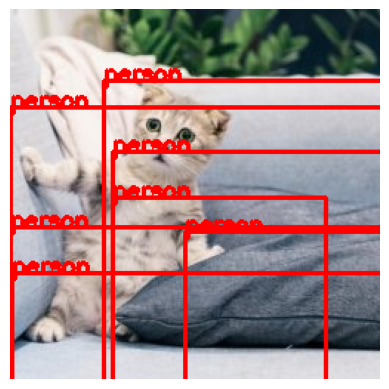

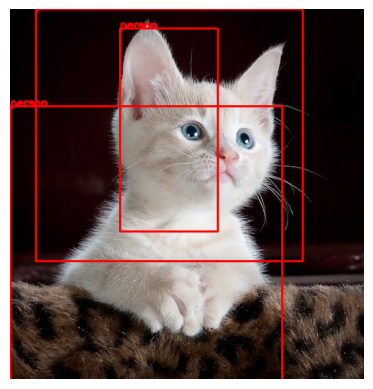

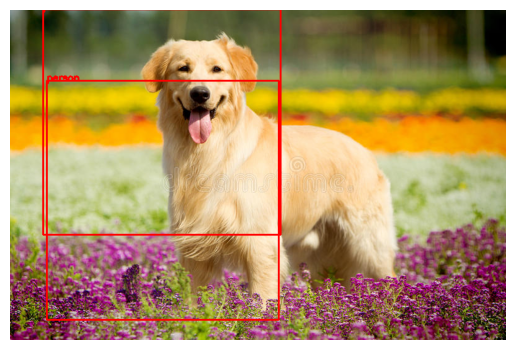

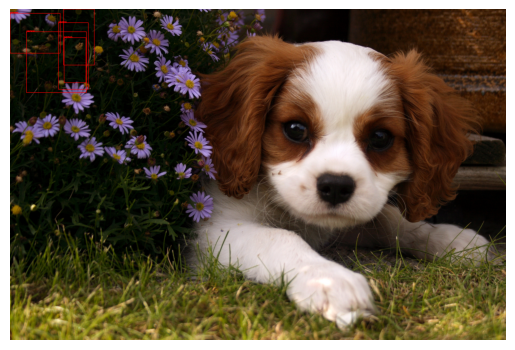

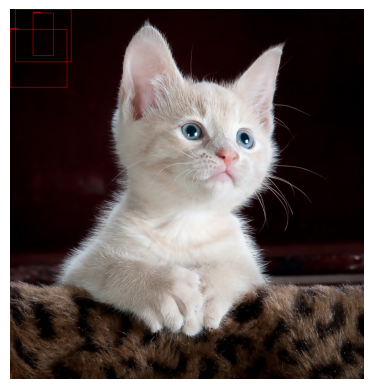

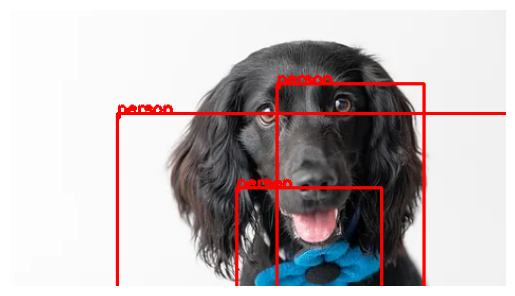

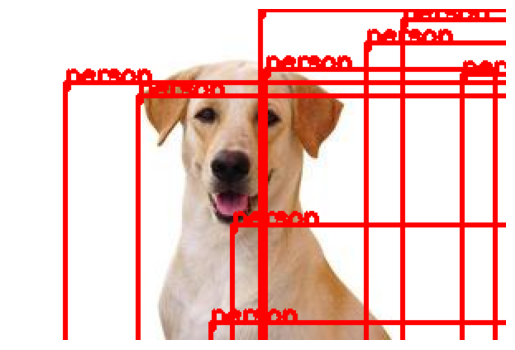

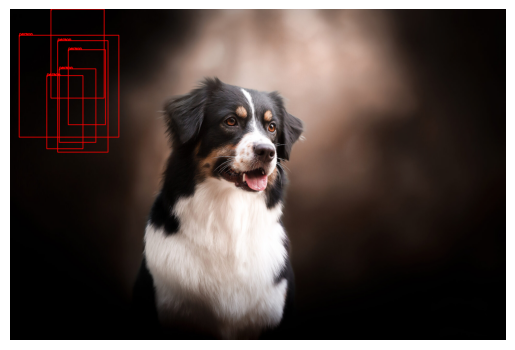

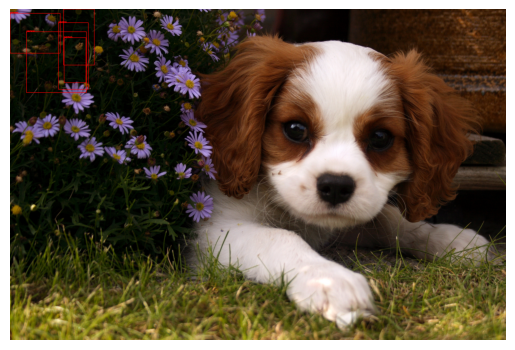

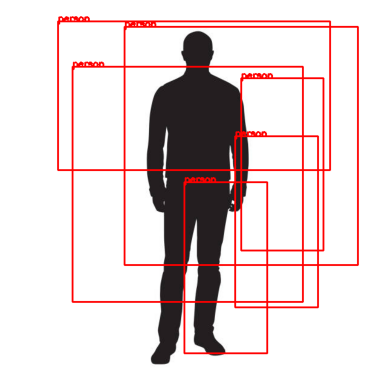

In [31]:
# Necessary imports
from google.colab import drive
import torch
import cv2
import matplotlib.pyplot as plt

# Mount the Google Drive
drive.mount('/content/drive')

# Define the inverse label map
inverse_label_map = {v: k for k, v in label_map.items()}

# Prediction function
def predict_image(image_path, model, transform, device, threshold=0.05):
    # Read and preprocess the image
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make predictions
    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor)

    # Visualize predictions
    image_with_boxes = image.copy()
    for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
        if score > threshold:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255,0,0), 2)
            cv2.putText(image_with_boxes, inverse_label_map[label.item()], (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()

# Set the device
device = torch.device('cuda')

# Load the trained weights
model_path = '/content/drive/MyDrive/model_weights_scratch_version.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# Predict for multiple images
image_paths = ['cat_1.jpg', 'cat_2.jpeg', 'dog.jpg', 'dog_6.jpg',
               'cat.jpg', 'dog_3.png', 'dog_4.jpg', 'dog_5.jpg', 'dog_6.jpg', 'person.jpg']
for img_path in image_paths:
    predict_image(img_path, model, transform, device)


### Video

In [ ]:
def predict_video(video_path, model, transform, threshold=0.5):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            image_tensor = transform(frame).unsqueeze(0).to(trainer.device)

            model.eval()
            with torch.no_grad():
                prediction = model(image_tensor)

            for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
                if score > threshold:
                    cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (255,0,0), 2)
                    cv2.putText(frame, str(label.item()), (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

            out.write(frame)

        else:
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Usage:
video_path = 'path_to_test_video.mp4'
predict_video(video_path, trainer.model, transform)


# Another approach

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a pre-trained model for the COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a new one for VOC (20 classes + background)
num_classes = 21  # 20 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Train and evaluate
from torchvision.models.detection import _utils as det_utils
from torchvision.models.detection.rpn import concat_box_prediction_layers

# This collate function takes care of image sizes being different
def collate_fn(batch):
    return tuple(zip(*batch))

# Loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)


import torch
from google.colab import drive
drive.mount('/content/drive')


class Trainer:
    def __init__(self, model, train_loader, test_loader, lr=0.005, momentum=0.9, weight_decay=0.0005, num_epochs=1):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
        self.num_epochs = num_epochs

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0.0
            for batch_idx, (batched_images, batched_targets) in enumerate(self.train_loader):
                images = [img.to(self.device) for img in batched_images]
                print(batched_targets)
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in batched_targets]

                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                total_loss += losses.item()

                self.optimizer.zero_grad()
                losses.backward()
                self.optimizer.step()

                if batch_idx % 10 == 0: # Print every 10 batches. You can change this as per your requirement.
                    print(f"Epoch [{epoch+1}/{self.num_epochs}], Batch [{batch_idx+1}/{len(self.train_loader)}], Loss: {losses.item()}")

            avg_loss = total_loss / len(self.train_loader)
            print(f"Epoch [{epoch+1}/{self.num_epochs}], Average Loss: {avg_loss}")

        print("Training Complete!")

    def predict(self):
        self.model.eval()
        with torch.no_grad():
            for images, _ in self.test_loader:
                images = list(img.to(self.device) for img in images)
                prediction = self.model(images)
                print(prediction)
                break

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved at {path}")

# Usage
trainer = Trainer(model, train_loader, test_loader, num_epochs=1)
trainer.train()
trainer.predict()
SAVE_PATH = '/content/drive/MyDrive/model_weights_well_pretrained.pth'
trainer.save_model(SAVE_PATH)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 62.3MB/s]


Streaming output truncated to the last 5000 lines.
        [109., 231., 118., 261.],
        [117., 233., 127., 261.],
        [125., 235., 135., 261.],
        [ 36.,  94.,  74., 159.],
        [391., 233., 500., 375.],
        [419., 241., 471., 266.]]), 'labels': tensor([8, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 8, 8])}, {'boxes': tensor([[ 37., 183.,  70., 199.],
        [255., 219., 349., 241.],
        [361., 173., 431., 203.]]), 'labels': tensor([7, 7, 7])})
({'boxes': tensor([[187., 123., 307., 500.],
        [ 93., 167., 209., 485.],
        [274., 267., 361., 413.],
        [ 33., 251.,  71., 341.],
        [  1., 191.,  39., 339.]]), 'labels': tensor([ 9,  9, 14, 13, 13])}, {'boxes': tensor([[  1.,  16., 403., 375.]]), 'labels': tensor([17])})
({'boxes': tensor([[ 44., 151., 110., 192.]]), 'labels': tensor([11])}, {'boxes': tensor([[ 89., 175., 181., 298.],
        [192., 171., 293., 282.],
        [197.,  89., 293., 239.],
        [ 86.,  95., 171., 265.],
        [ 98.,  77.,

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


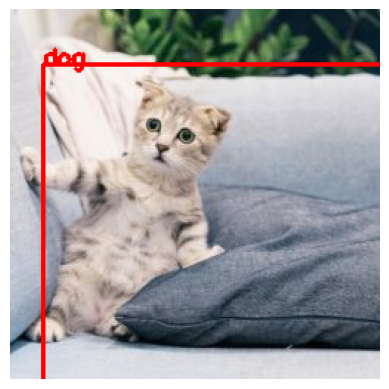

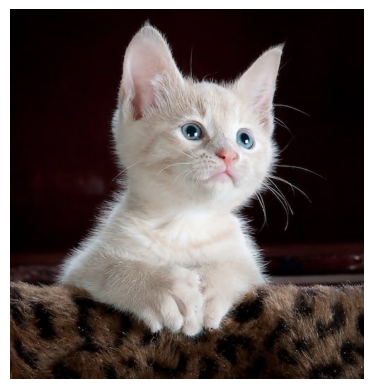

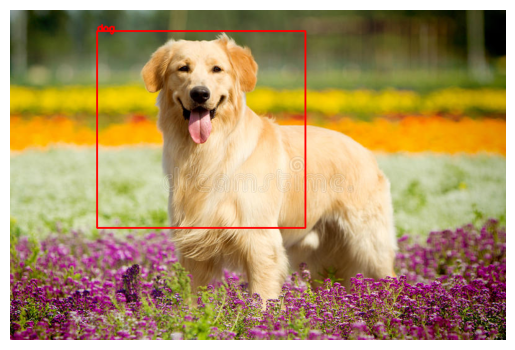

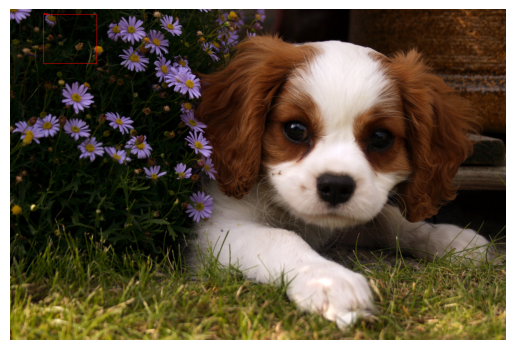

In [ ]:
import matplotlib.pyplot as plt
import cv2
import torch

inverse_label_map = {v: k for k, v in label_map.items()}

def predict_image(image_path, model, transform, device, threshold=0.6):
    # Read and preprocess the image
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image_tensor = transform(image).unsqueeze(0).to(device)  # Send to device


    # Make predictions
    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor)

    # Visualize predictions
    image_with_boxes = image.copy()
    for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
        if score > threshold:
            # Convert tensor box coordinates to integer values
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255,0,0), 2)
            # Use the inverse_label_map to get the class name from the predicted label
            cv2.putText(image_with_boxes, inverse_label_map[label.item()], (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()



from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/model_weights_well_pretrained.pth'
model.load_state_dict(torch.load(model_path))
model.to(torch.device('cuda'))
model.eval()  # Ensure the model is in evaluation mode

# Usage:
image_path = 'cat_1.jpg'
predict_image(image_path, trainer.model, transform, device)
image_path = 'cat_2.jpeg'
predict_image(image_path, trainer.model, transform, device)
image_path = 'dog.jpg'
predict_image(image_path, trainer.model, transform, device)
image_path = 'dog_6.jpg'
predict_image(image_path, trainer.model, transform, device)